This notebook was based on the Kaggle competition below, and executed as a final project for a Data Science Bootcamp, ministered by [Alura](https://www.alura.com.br/).

It was written by Brian Lear.

* LinkedIn: https://www.linkedin.com/in/brian-lear-155bb745/
* GitHub: https://github.com/brian-lear

# **COVID-19 - Clinical Data to assess diagnosis** -> [Kaggle submission](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)

Context

COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources.
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20.

Call to action

There is urgency in obtaining accurate that to better predict and prepare healthcare systems and avoid collapse, defined by above capacity need of ICU beds (assuming human resources, PPE and professionals are available), using individual clinical data - in lieu of epidemiological and populational data.**

**Window Concept**

The original data contains information about specific Patients and their stay at the hospital, comprised of 5 rows per patient,being each row referent to a time window, as per below.

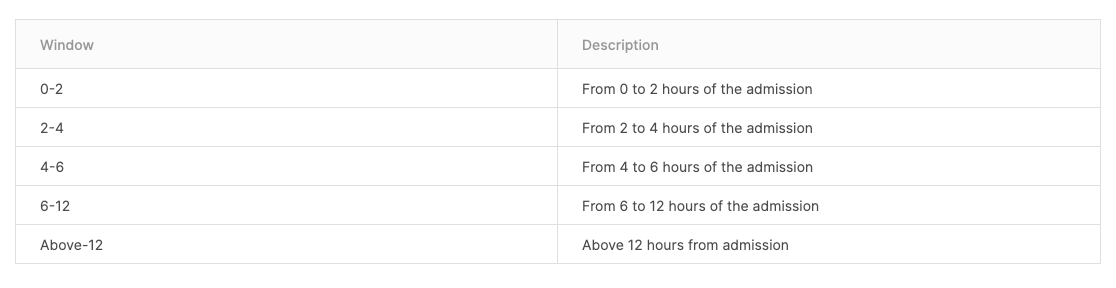

Another relevant instruction is that we should not use patient information related to the row when it is already in the ICU, as we do not know whether the information was measured prior or after the patient being sent to the ICU.

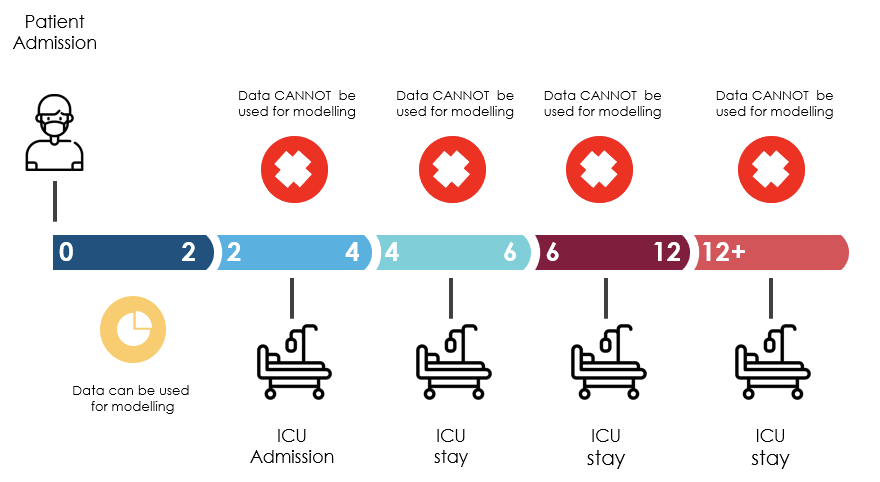

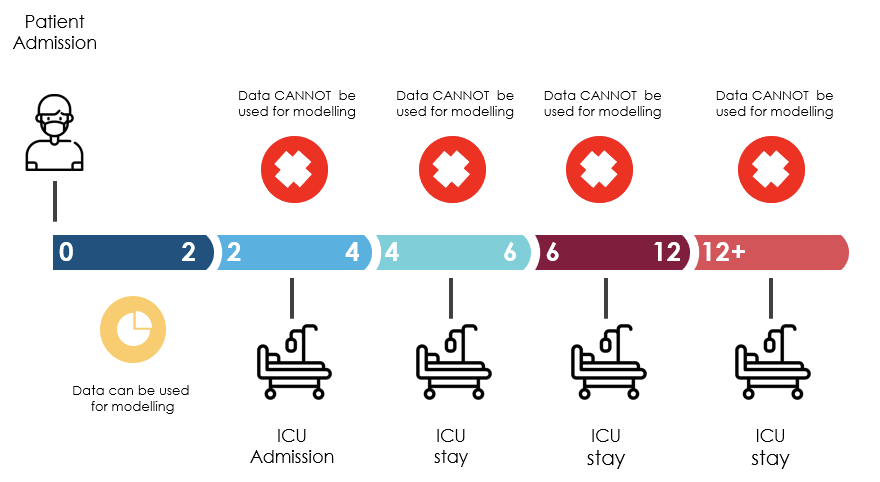

# Chosen approach

The primary goal is to have a good model predicting whether a pacient that was not sent to the ICU on the first window (0-2 hours) will be sent on the following window (2-4 hours). After pondering about the task at hand, I decided to tackle the other windows as well. Hence, there are 4 models, each for a w0 (window0) and a prediction for the w1, focused on predicting who will be sent to the ICU.

In order to determine which model to choose, I created 4 dataframes, for each combination of w0 and w1, while including new features, which were the lagging memory of how the other features changed (non categorical ones). For instance, how much did the blood tests improved or worsened between windows, and that information was carried to following dataframes, leaving the dataframde for the last window (6-12 hours predicting ICU in Above 12h), with lagged difference features between windows [0-2 and 4-6], [4-6 and 6-12], etc. 

I then ran those 4 dataframes throught a Logistic Regression, a Extra Trees and a LGBM, all with hyperopt. After analysing the final results using cross validation, with F1 score, Recall, Average Precision and AUC, I chose the best model for each window.

After creating those 4 final models, I decided to analyse the combined probability of a patient ever going to the ICU. In order to do so, I created 4 new dataframes, but this time all had the same features, since using features dereived from past data would not make sense in this case. With those 4 dataframes in hand, I ran them through the same models, and underwent the same model selection. 

The idea was to use the predict_proba for each model, but for Tree models, the predict proba is not calibrated, which means it can't be used as we would use predict proba from a Logistic Regression. Therefore, before I could use the predict probas, I needed to calibrate the ones that were generated using a tree model. That was achieved by fitting the leaves of the Tree Models with a Logistic Regression, and using the predict proba from the Logistic Regression. With the calibrated probas in hand, I then sumed all probas, which gave me the combined probability that a pacient would be sent to the ICU at any given time.

# Examples of created features

The feature creating technique below was used with all non categorical information, in order to try to capture if results changing overtime had a positive or negative impact on the prediction.

* RESPIRATORY_RATE_DIFF: original variable, related to the original dataset
* RESPIRATORY_RATE_DIFF_windif_2: feature created by checking if there was a difference between RESPIRATORY_RATE_DIFF(window 2-4) to RESPIRATORY_RATE_DIFF(window 0-2)
* RESPIRATORY_RATE_DIFF_windif_3: feature created by checking if there was a difference between RESPIRATORY_RATE_DIFF(window 4-6) to RESPIRATORY_RATE_DIFF(window 2-4)
* RESPIRATORY_RATE_DIFF_windif_4: feature created by checking if there was a difference between RESPIRATORY_RATE_DIFF(window 6-12) to RESPIRATORY_RATE_DIFF(window 4-6)

# Target variable

The target 'next_period_ICU' was created in order to capture the information if, for each patient, they were sent to the ICU on the next window. In that way, with initial data from a window, it could be predicted whether the patient would need an ICU spot on the following window, which would greatly improve the hospital's logistics and efficiency.

# Libs and defs

In [1]:
!pip install 'openpyxl'

     |████████████████████████████████| 243 kB 870 kB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=111d3bf37831aec6ea5845472f65b475a14a0d62c13f7206d4d0f3510a3e9897
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [2]:
import numpy as np
import pandas as pd
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate


from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

import time

notebook_start = time.time()

/kaggle/input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx


In [3]:
# features used by Sirio Libanes' Hospital

def makebio_df(df:pd.DataFrame):

    df["BLOODPRESSURE_ARTERIAL_MEAN"] = (df['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
 
    df["NEUTROPHILES/LINFOCITOS"] = df['NEUTROPHILES_MEAN']/df['LINFOCITOS_MEAN']

    df["GASO"] = df.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
    df["GASO"] = (~df["GASO"].isna()).astype(int)

    return df[["ICU","WINDOW",
               "PATIENT_VISIT_IDENTIFIER",
               "AGE_ABOVE65", 
               "GENDER", 
               "BLOODPRESSURE_ARTERIAL_MEAN", 
               "RESPIRATORY_RATE_MAX", 
               "HTN", 
               'DISEASE GROUPING 1',
               'DISEASE GROUPING 2',
               'DISEASE GROUPING 3',
               'DISEASE GROUPING 4',
               'DISEASE GROUPING 5',
               'DISEASE GROUPING 6',
               "GASO",
               "OXYGEN_SATURATION_MIN",
               "HEART_RATE_MAX",
               "PCR_MEAN",
               "CREATININ_MEAN"]]

In [4]:
# creates a new df based on selected window,next one i.e.(0-2,2-4) for ICU prediction and previous one for feature temporal differences

def window_df_creation(df_base):
# first, we create our 0-2 WINDOW dataframe

    starting_window = '0-2' 
    ending_window = '2-4'
#     slicing df to match selected Windows
    df = df_base.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df1 = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df1 = df1[(df1['WINDOW']==starting_window)]
    df1 = df1.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df1 = pd.get_dummies(df1)
    df1.index = df1['PATIENT_VISIT_IDENTIFIER']


    
    
# creating 2-4 WINDOW df
    
    starting_window = '2-4' 
    ending_window = '4-6'
    dif_window = '0-2'
    
    #     slicing df to match selected Windows
    df = df_best_features.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
#     remove starting_window ICU patients
    remove_patients = df[(df['WINDOW']==starting_window) & (df['ICU']==1)]['PATIENT_VISIT_IDENTIFIER'].to_list()

    df = df.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
    df = df.reset_index(drop=True)
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df = df[(df['WINDOW']==starting_window)]
    df = df.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df = pd.get_dummies(df)
    df['WINDOW'] = starting_window
    df.index = df['PATIENT_VISIT_IDENTIFIER']
        
    df_dif_list = []
    for x in df[(df['WINDOW']==starting_window)].index:
        df_end = df_best_features[(df_best_features['WINDOW']==starting_window) & (df_best_features['PATIENT_VISIT_IDENTIFIER']==x)]
        df_end = df_end.drop(columns=['WINDOW'])

        df_init = df_best_features[(df_best_features['WINDOW']==dif_window) & (df_best_features['PATIENT_VISIT_IDENTIFIER']==x)]
        df_init = df_init.drop(columns=['WINDOW'])
        df_init = df_init.values.tolist()[0]

        df_dif2 = df_end.sub(df_init, axis='columns')

        df_dif2['PATIENT_VISIT_IDENTIFIER'] = x
        df_dif2['WINDOW'] = starting_window
        dif_vector = df_dif2.values.tolist()[0] 
        df_dif_list.append(dif_vector)

    df_dif2 = pd.DataFrame(df_dif_list)

    # new headers for dif columns
    dif_headers = [f"{x}_windif_2" for x in df_best_features.columns.to_list()]
    new_col = ['WINDOW']
    dif_headers_new = dif_headers + new_col
    dif_headers_new[0] = 'PATIENT_VISIT_IDENTIFIER'
    dif_headers_new.remove('WINDOW_windif_2')
    dif_headers_new

    df_dif2.columns = dif_headers_new
    df_dif2.drop(columns=['WINDOW','AGE_ABOVE65_windif_2','DISEASE GROUPING 2_windif_2','DISEASE GROUPING 3_windif_2','DISEASE GROUPING 4_windif_2','DISEASE GROUPING 5_windif_2','ICU_windif_2','AGE_PERCENTIL_10th_windif_2','AGE_PERCENTIL_20th_windif_2','AGE_PERCENTIL_80th_windif_2','AGE_PERCENTIL_90th_windif_2','AGE_PERCENTIL_Above 90th_windif_2'],inplace=True)

#     merging dfs to create final df
    df2 = df.merge(df_dif2,left_index = True,right_on='PATIENT_VISIT_IDENTIFIER')
    df2.index = df2['PATIENT_VISIT_IDENTIFIER']
    df2.drop(columns=['PATIENT_VISIT_IDENTIFIER','WINDOW'],inplace=True)
    

    
    
    
    
# creating 4-6 WINDOW df
    
    starting_window = '4-6' 
    ending_window = '6-12'
    dif_window = '2-4'
    
    #     slicing df to match selected Windows
    df = df_best_features.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
    #     remove starting_window ICU patients
    remove_patients = df[(df['WINDOW']==starting_window) & (df['ICU']==1)]['PATIENT_VISIT_IDENTIFIER'].to_list()

    df = df.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
    df = df.reset_index(drop=True)
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df = df[(df['WINDOW']==starting_window)]
    df = df.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df = pd.get_dummies(df)
    df['WINDOW'] = starting_window
    df.index = df['PATIENT_VISIT_IDENTIFIER']
        
    df_dif_list = []
    for x in df[(df['WINDOW']==starting_window)].index:
        df_end = df_best_features[(df_best_features['WINDOW']==starting_window) & (df_best_features['PATIENT_VISIT_IDENTIFIER']==x)]
        df_end = df_end.drop(columns=['WINDOW'])

        df_init = df_best_features[(df_best_features['WINDOW']==dif_window) & (df_best_features['PATIENT_VISIT_IDENTIFIER']==x)]
        df_init = df_init.drop(columns=['WINDOW'])
        df_init = df_init.values.tolist()[0]

        df_dif3 = df_end.sub(df_init, axis='columns')

        df_dif3['PATIENT_VISIT_IDENTIFIER'] = x
        df_dif3['WINDOW'] = starting_window
        dif_vector = df_dif3.values.tolist()[0] 
        df_dif_list.append(dif_vector)

    df_dif3 = pd.DataFrame(df_dif_list)

    # new headers for dif columns
    dif_headers = [f"{x}_windif_4" for x in df_best_features.columns.to_list()]
    new_col = ['WINDOW']
    dif_headers_new = dif_headers + new_col
    dif_headers_new[0] = 'PATIENT_VISIT_IDENTIFIER'
    dif_headers_new.remove('WINDOW_windif_4')
    dif_headers_new

    df_dif3.columns = dif_headers_new
    df_dif3.drop(columns=['WINDOW','AGE_ABOVE65_windif_4','DISEASE GROUPING 2_windif_4','DISEASE GROUPING 3_windif_4','DISEASE GROUPING 4_windif_4','DISEASE GROUPING 5_windif_4','ICU_windif_4','AGE_PERCENTIL_10th_windif_4','AGE_PERCENTIL_20th_windif_4','AGE_PERCENTIL_80th_windif_4','AGE_PERCENTIL_90th_windif_4','AGE_PERCENTIL_Above 90th_windif_4'],inplace=True)

    
    #     merging dfs to create final df
    df3 = df.merge(df_dif3,left_index = True,right_on='PATIENT_VISIT_IDENTIFIER')
    df3 = df3.merge(df_dif2,left_on = 'PATIENT_VISIT_IDENTIFIER',right_on='PATIENT_VISIT_IDENTIFIER')
    df3.index = df3['PATIENT_VISIT_IDENTIFIER_x']
    df3.drop(columns=['PATIENT_VISIT_IDENTIFIER','PATIENT_VISIT_IDENTIFIER_x','WINDOW'],inplace=True)
    

    
    
# creating 6-12 WINDOW df
    
    starting_window = '6-12' 
    ending_window = 'ABOVE_12'
    dif_window = '4-6'
    
    #     slicing df to match selected Windows
    df = df_best_features.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
    #     remove starting_window ICU patients
    remove_patients = df[(df['WINDOW']==starting_window) & (df['ICU']==1)]['PATIENT_VISIT_IDENTIFIER'].to_list()

    df = df.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
    df = df.reset_index(drop=True)
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df = df[(df['WINDOW']==starting_window)]
    df = df.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df = pd.get_dummies(df)
    df['WINDOW'] = starting_window
    df.index = df['PATIENT_VISIT_IDENTIFIER']
        
    df_dif_list = []
    for x in df[(df['WINDOW']==starting_window)].index:
        df_end = df_best_features[(df_best_features['WINDOW']==starting_window) & (df_best_features['PATIENT_VISIT_IDENTIFIER']==x)]
        df_end = df_end.drop(columns=['WINDOW'])

        df_init = df_best_features[(df_best_features['WINDOW']==dif_window) & (df_best_features['PATIENT_VISIT_IDENTIFIER']==x)]
        df_init = df_init.drop(columns=['WINDOW'])
        df_init = df_init.values.tolist()[0]

        df_dif4 = df_end.sub(df_init, axis='columns')

        df_dif4['PATIENT_VISIT_IDENTIFIER'] = x
        df_dif4['WINDOW'] = starting_window
        dif_vector = df_dif4.values.tolist()[0] 
        df_dif_list.append(dif_vector)

    df_dif4 = pd.DataFrame(df_dif_list)

    # new headers for dif columns
    dif_headers = [f"{x}_windif_6" for x in df_best_features.columns.to_list()]
    new_col = ['WINDOW']
    dif_headers_new = dif_headers + new_col
    dif_headers_new[0] = 'PATIENT_VISIT_IDENTIFIER'
    dif_headers_new.remove('WINDOW_windif_6')
    dif_headers_new

    df_dif4.columns = dif_headers_new
    df_dif4.drop(columns=['WINDOW','AGE_ABOVE65_windif_6','DISEASE GROUPING 2_windif_6','DISEASE GROUPING 3_windif_6','DISEASE GROUPING 4_windif_6','DISEASE GROUPING 5_windif_6','ICU_windif_6','AGE_PERCENTIL_10th_windif_6','AGE_PERCENTIL_20th_windif_6','AGE_PERCENTIL_80th_windif_6','AGE_PERCENTIL_90th_windif_6','AGE_PERCENTIL_Above 90th_windif_6'],inplace=True)

    
    #     merging dfs to create final df
    df4 = df.merge(df_dif4,left_index = True,right_on='PATIENT_VISIT_IDENTIFIER')
    df4 = df4.merge(df_dif2,left_on = 'PATIENT_VISIT_IDENTIFIER',right_on='PATIENT_VISIT_IDENTIFIER')
    df4 = df4.merge(df_dif3,left_on = 'PATIENT_VISIT_IDENTIFIER',right_on='PATIENT_VISIT_IDENTIFIER')
    df4.index = df4['PATIENT_VISIT_IDENTIFIER_x']
    df4.drop(columns=['PATIENT_VISIT_IDENTIFIER','PATIENT_VISIT_IDENTIFIER_x','PATIENT_VISIT_IDENTIFIER_y','WINDOW'],inplace=True)
    
    return df1,df2,df3,df4

In [5]:
# creates new dfs to be used with proba combination

def df_proba_create(df_base):

    # first, we create our 0-2 WINDOW dataframe

    starting_window = '0-2' 
    ending_window = '2-4'
#     slicing df to match selected Windows
    df = df_base.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df1 = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df1 = df1[(df1['WINDOW']==starting_window)]
    df1 = df1.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df1 = pd.get_dummies(df1)
    df1.index = df1['PATIENT_VISIT_IDENTIFIER']
    df1.drop(columns=['PATIENT_VISIT_IDENTIFIER'], inplace = True)
    

    
    
    # 2-4 WINDOW dataframe

    starting_window = '0-2' 
    ending_window = '4-6'
#     slicing df to match selected Windows
    df = df_base.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
    #     remove starting_window ICU patients
    remove_patients = df[(df['WINDOW']==starting_window) & (df['ICU']==1)]['PATIENT_VISIT_IDENTIFIER'].to_list()

    df = df.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
    df = df.reset_index(drop=True)
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df2 = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df2 = df2[(df2['WINDOW']==starting_window)]
    df2 = df2.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df2 = pd.get_dummies(df2)
    df2.index = df2['PATIENT_VISIT_IDENTIFIER']
    df2.drop(columns=['PATIENT_VISIT_IDENTIFIER'], inplace = True)
    

    # 4-6 WINDOW dataframe

    starting_window = '0-2' 
    ending_window = '6-12'
#     slicing df to match selected Windows
    df = df_base.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
    #     remove starting_window ICU patients
    remove_patients = df[(df['WINDOW']==starting_window) & (df['ICU']==1)]['PATIENT_VISIT_IDENTIFIER'].to_list()

    df = df.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
    df = df.reset_index(drop=True)
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df3 = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df3 = df3[(df3['WINDOW']==starting_window)]
    df3 = df3.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df3 = pd.get_dummies(df3)
    df3.index = df3['PATIENT_VISIT_IDENTIFIER']
    df3.drop(columns=['PATIENT_VISIT_IDENTIFIER'], inplace = True)
    

    # 6-12 WINDOW dataframe

    starting_window = '0-2' 
    ending_window = 'ABOVE_12'
#     slicing df to match selected Windows
    df = df_base.copy()
    df = df[(df['WINDOW']==starting_window)|(df['WINDOW']==ending_window)]
    
    #     remove starting_window ICU patients
    remove_patients = df[(df['WINDOW']==starting_window) & (df['ICU']==1)]['PATIENT_VISIT_IDENTIFIER'].to_list()

    df = df.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
    df = df.reset_index(drop=True)
    
#     creating feature identifying if patient went to the ICU on the ending_window    
    next_period_icu = df.groupby(['PATIENT_VISIT_IDENTIFIER'])['WINDOW','ICU'].sum()
    next_period_icu = next_period_icu.rename(columns={'ICU':'next_period_ICU'})
    
#     adding new columns to starting_window rows
    df4 = df.merge(next_period_icu,left_on='PATIENT_VISIT_IDENTIFIER',right_index=True)
    df4 = df4[(df4['WINDOW']==starting_window)]
    df4 = df4.drop(columns=['WINDOW','AGE_ABOVE65','ICU'])
    
#     transforming categorical data to dummies and setting index as unique ID (Patient ID)
    df4 = pd.get_dummies(df4)
    df4.index = df4['PATIENT_VISIT_IDENTIFIER']
    df4.drop(columns=['PATIENT_VISIT_IDENTIFIER'], inplace = True)
    
    return df1,df2,df3,df4

In [6]:
def train_test(df):
    features = df.columns.to_list()
    features.remove('next_period_ICU')
    
    x=df[features]
    y=df['next_period_ICU']
    
    X_train, X_test, y_train, y_test = train_test_split(x,y,stratify = y,random_state = 42, test_size=0.20)
    return X_train, X_test, y_train, y_test, x, y

In [7]:
def model_comparison(df):
    
#     train test split
    X_train, X_test, y_train, y_test, x_full, y_full = train_test(df)  
    
    
    
    ###############     Logistic Regression     ###############
    
    init_time = time.time()
    
        ###### Hyperoptimization ######
    lr_params = {
        'C': np.random.uniform(low=0.0, high=1.0, size=1000),
        'penalty': ['l1', 'l2'],
        'max_iter': np.random.uniform(low=2000, high=10000, size=1000),
    }

    lr_random_search_model = RandomizedSearchCV(
        estimator=LogisticRegression(
            fit_intercept=True,
            class_weight='balanced',
            random_state=42
        ), 
        param_distributions=lr_params,
        scoring='f1',
        cv=4,
        n_iter=2000,
        n_jobs=-1,
        random_state=42
    )

    lr_random_search_model.fit(x_full, y_full)
    lr_best_model = lr_random_search_model.best_estimator_

    
    ###### Evaluating hyperopt ######
    y_pred_test = lr_best_model.predict(x_full)
    y_prob_test = lr_best_model.predict_proba(x_full)[:, 1]

    lr_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

    _,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
    lr_f1_score_test = round(f1_score_test[1],4)
    lr_recall_test = round(recall_test[1],4)

    lr_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

    end_time = time.time()
    lr_fit_time = round((end_time - init_time)/60,2)
    
    print(f"Logistic Regression done in {lr_fit_time} minutes")
    
    
    ###############     Extra Trees     ############### 
    
    init_time = time.time()


    # Hyperparameter grid
    param_grid = {
        'n_estimators': np.linspace(1500, 3000).astype(int),
        'max_depth': list(np.linspace(2, 4).astype(int)),
        'max_features': ['auto', 'sqrt'],
        'max_samples': list(np.arange(0.5, 1, 0.1)),
        'min_samples_split': [5, 10, 20],
        'bootstrap': [True, False]
    }

    # Estimator for use in random search
    estimator = ExtraTreesClassifier(class_weight='balanced',random_state=42)

    # Create the random search model
    xtrees_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                            scoring = 'f1', cv = 3, 
                            n_iter = 100, verbose = 0,
                            random_state=42)

    # Fit 
    xtrees_model.fit(x_full, y_full)
    xt_best_model = xtrees_model.best_estimator_


    ###### Evaluating hyperopt - test ######
    y_pred_test = xt_best_model.predict(x_full)
    y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

    xt_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

    _,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
    xt_f1_score_test = round(f1_score_test[1],4)
    xt_recall_test = round(recall_test[1],4)

    xt_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

    end_time = time.time()
    xt_fit_time = round((end_time - init_time)/60,2)
    print(f"Extra Trees done in {xt_fit_time} minutes")
    
    
    
    ###############     LGBM     ###############

    init_time = time.time()


    # Hyperparameter grid
    param_grid = {"n_estimators": np.linspace(2, 5).astype(int),
                  "boosting_type": ["gbdt","dart","goss"],
                  "subsample": list(np.arange(0.5, 1, 0.2)),
                  "colsample_bytree": list(np.arange(0.5, 0.8, 0.1)),
                  "objective": ["binary","multiclass"],
                  "alpha": list(np.arange(0, 0.6, 0.2)),
                  "max_depth": [2,3,4,5,6],
                  "num_leaves": np.linspace(20, 40).astype(int),
                 }

    # Estimator for use in random search
    estimator = LGBMClassifier(class_weight='balanced',random_state=42)

    # Create the random search model
    lgbm = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                            scoring = 'f1', cv = 5, 
                            n_iter = 100, verbose = 0,
                            random_state=42)

    # Fit 
    lgbm.fit(x_full, y_full)
    lgbm_best_model = lgbm.best_estimator_

    ###### Evaluating hyperopt - test ######
    y_pred_test = lgbm_best_model.predict(x_full)
    y_prob_test = lgbm_best_model.predict_proba(x_full)[:, 1]

    lgbm_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

    _,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
    lgbm_f1_score_test = round(f1_score_test[1],4)
    lgbm_recall_test = round(recall_test[1],4)

    lgbm_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

    end_time = time.time()
    lgbm_fit_time = round((end_time - init_time)/60,2)
    print(f"LGBM done in {lgbm_fit_time} minutes")
    
    
    ###############     Model comparison table     ###############
    
    
    print(
    tabulate(
        [
            ["Model", "F1-score", "Recall", "AUC", "Avg Precision"],
            [
                "Logistic Regression",
                lr_f1_score_test,
                lr_recall_test,
                lr_auc_score_test,
                lr_avg_prec_test,          
            ],
            [
                "Extra Trees",
                xt_f1_score_test,
                xt_recall_test,
                xt_auc_score_test,
                xt_avg_prec_test,
            ],
            [
                "LGBM",
                lgbm_f1_score_test,
                lgbm_recall_test,
                lgbm_auc_score_test,
                lgbm_avg_prec_test
            ],
        ]
    )
)
    
    return lr_best_model, xt_best_model, lgbm_best_model

In [8]:
# plots ROC AUC curve
def roc_auc_plot(y_test, y_prob):
  
  # get roc/auc info
  fpr = dict()
  tpr = dict()
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = dict()
  roc_auc = round(auc(fpr, tpr),3)

  # make the plot
  fig = plt.figure(figsize=(10,10))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)
  plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
  plt.legend(loc="lower right", shadow=True, fancybox =True)

In [9]:
# function to transform predict_proba values for Tree based models, by using Logistic Regression (based on https://gdmarmerola.github.io/probability-calibration/)

def lr_proba(model,df):
    
    features = df.columns.to_list()
    features.remove('next_period_ICU')

    X=df[features]
    y=df['next_period_ICU']
    x_id=df.index.values

    if str(model)[:3] == 'LGB':
        leaves = model.predict(X,pred_leaf = True)
    else:
        # then, we apply the model to the data in order to get the leave indexes
        leaves = model.apply(X)
        
    encoder = OneHotEncoder()
    leaves_encoded = encoder.fit_transform(leaves)

    # parameters obtained via random search
    lr_params = {'solver':'sag',
                 'C': 0.001756	,
                 'fit_intercept': False}

    lr = LogisticRegression(**lr_params)
    lr.fit(leaves_encoded, y)

    if str(model)[:3] == 'LGB':
        leaves = model.predict(X,pred_leaf = True)
    else:
        # then, we apply the model to the data in order to get the leave indexes
        leaves = model.apply(X)

    # then, we one-hot encode the leave indexes so we can use them in the logistic regression
    leaves_encoded = encoder.transform(leaves)

    # and fit it to the encoded leaves
    y_hat = lr.predict_proba(leaves_encoded)

    # retuning probabilities
    df_yhat = pd.DataFrame(y_hat)
    df_xid = pd.DataFrame(x_id)
    df_xid.columns = ['id']
    
    df_mix = df_xid.merge(df_yhat,left_index = True, right_index = True)
    df_mix.index = df_mix['id']
    df_mix.drop(columns=['id'],inplace=True)
    
    return df_mix

# Importing and handling data

In [10]:
pd.set_option('display.max_columns', None)
df = pd.read_excel("/kaggle/input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [11]:
df_raw = df.copy()

In [12]:
# Adding new features based on features used by hospital

df_raw["BLOODPRESSURE_ARTERIAL_MEAN"] = (df_raw['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df_raw['BLOODPRESSURE_DIASTOLIC_MEAN'])/3
 
df_raw["NEUTROPHILES/LINFOCITOS"] = df_raw['NEUTROPHILES_MEAN']/df_raw['LINFOCITOS_MEAN']

df_raw["GASO"] = df_raw.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
df_raw["GASO"] = (~df_raw["GASO"].isna()).astype(int)

In [13]:
df_raw.shape

(1925, 234)

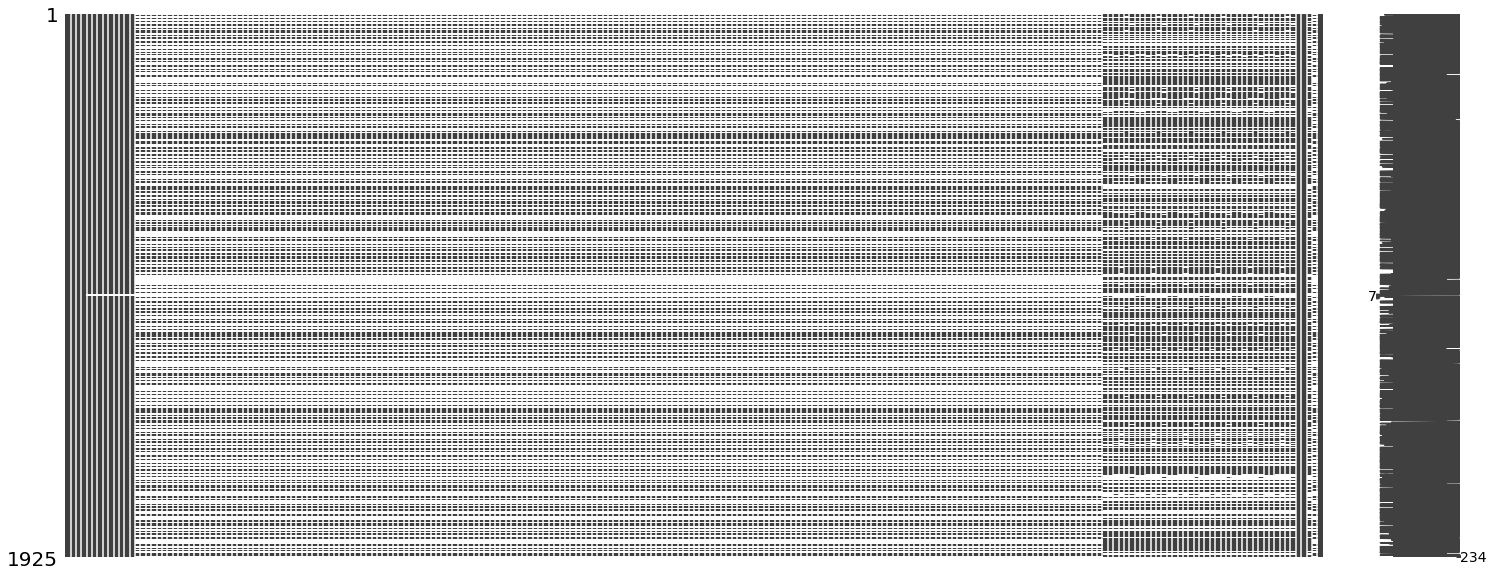

In [14]:
missingno.matrix(df_raw)
plt.show()

In [15]:
#####  removing when patient was sent to the ICU in the first window

remove_patients = df_raw.query("WINDOW == '0-2' and ICU == 1")['PATIENT_VISIT_IDENTIFIER'].to_list()

df_raw = df_raw.query("PATIENT_VISIT_IDENTIFIER not in @remove_patients")
df_raw = df_raw.reset_index(drop=True)

# making sure there are no spaces in column names
df_raw.columns = df_raw.columns.map(lambda x: x.strip())

In [16]:
# removed 32 patients that were sent to the ICU on during the first window (0-2 hours)

df_raw.shape

(1765, 234)

In [17]:
# creating list with float features

new_floats = ['BLOODPRESSURE_ARTERIAL_MEAN','NEUTROPHILES/LINFOCITOS']
float_features_columns = df.iloc[:,13:-2].columns.to_list()
float_features_columns = float_features_columns + new_floats

# creating list with cat features

new_cat = ['GASO']
cat_features_columns = df.iloc[:,:13].columns.to_list()
cat_features_columns = cat_features_columns + new_cat

# creating list with outputs
outputs_columns = df.iloc[:,-2:].columns.to_list()

In [18]:
# in order not to use ICU rows to do a backfill, created a df with no ICU rows in order to do the backfill
df_no_icu = df_raw.query("ICU != 1.0")

float_features_no_icu = df_no_icu.groupby('PATIENT_VISIT_IDENTIFIER',as_index=False)[float_features_columns].fillna(method='bfill').fillna(method='ffill')
cat_features_no_icu = df_no_icu.groupby('PATIENT_VISIT_IDENTIFIER',as_index=False)[cat_features_columns].fillna(method='bfill').fillna(method='ffill')
output_no_icu = df_no_icu[outputs_columns]

df_no_icu_concat = pd.concat([cat_features_no_icu,float_features_no_icu,output_no_icu], ignore_index=True, axis=1)
new_headers = cat_features_columns + float_features_columns + outputs_columns
df_no_icu_concat.columns = new_headers
df_no_icu_concat.shape

(1410, 234)

In [19]:
# creating df with first row when Patient was sent to the ICU
df_icu = df_raw.query("ICU == 1.0").reset_index()
df_icu = df_icu.groupby('PATIENT_VISIT_IDENTIFIER').first().reset_index()

float_features_icu = df_icu.groupby('PATIENT_VISIT_IDENTIFIER',as_index=False)[float_features_columns].fillna(method='bfill').fillna(method='ffill')
float_features_icu.index = df_icu['index']
cat_features_icu = df_icu.groupby('PATIENT_VISIT_IDENTIFIER',as_index=False)[cat_features_columns].fillna(method='bfill').fillna(method='ffill')
cat_features_icu.index = df_icu['index']
output_icu = df_icu[outputs_columns]
output_icu.index = df_icu['index']

df_icu.drop(columns=['index'],inplace=True)
df_icu_concat = pd.concat([cat_features_icu,float_features_icu,output_icu], ignore_index=True, axis=1)
df_icu_concat.columns = new_headers
df_icu_concat.shape

(163, 234)

In [20]:
# concatenating ICU and no ICU dataframes
df_concat = pd.concat([df_no_icu_concat,df_icu_concat], ignore_index=False, axis=0)
df_concat = df_concat.sort_index()
df_concat.shape

(1573, 234)

In [21]:
# transforming categorical data to dummies
df_dummies = df_concat[['PATIENT_VISIT_IDENTIFIER','AGE_PERCENTIL']].copy()
df_dummies = pd.get_dummies(df_dummies)
df_dummies = df_dummies.drop_duplicates()

# joining new dummy features
df_concat = df_concat.drop(columns=['AGE_PERCENTIL'])
df_concat = df_concat.merge(df_dummies,left_on = 'PATIENT_VISIT_IDENTIFIER',right_on = 'PATIENT_VISIT_IDENTIFIER')

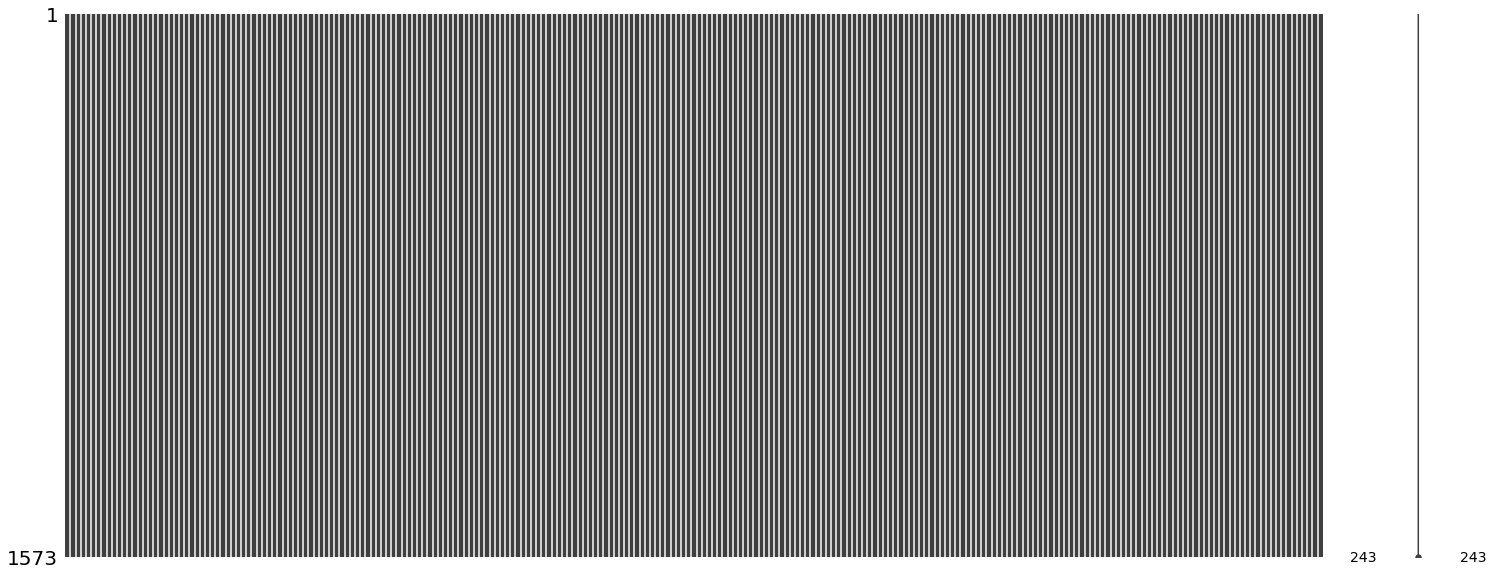

In [22]:
# checking again visually for gaps in data
missingno.matrix(df_concat)
plt.show()

In [23]:
# There are no NULL values in df
df_concat.columns[df_concat.isna().any()].tolist()

[]

In [24]:
# in order to remove columns with no variance, the second position of a value_counts will be searched. When no number returns, it means the feature has only one value
drop_columns_no_variance = []
for x in df_concat.columns:
    try :
        has_variance = df_concat[x].value_counts().to_list()[1]
    except Exception:
        drop_columns_no_variance.append(x)
        continue

In [25]:
len(drop_columns_no_variance)

36

In [26]:
# there are 36 values that have no variance and will be removed
df_concat.drop(columns=drop_columns_no_variance,inplace=True)
df_concat.shape

(1573, 207)

In [27]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1573 entries, 0 to 1572
Columns: 207 entries, PATIENT_VISIT_IDENTIFIER to AGE_PERCENTIL_Above 90th
dtypes: float64(191), int64(5), object(1), uint8(10)
memory usage: 2.4+ MB


In [28]:
# highly or perfectly correlated features should be removed. In order to do that, I checked tbe number of times a feature had a correlation of 1 with another one. Then I removed N-1 oif those features.

correlation_mat = df_concat.corr()
correlation_mat

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,GASO,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
PATIENT_VISIT_IDENTIFIER,1.000000,-0.031265,0.074006,0.048391,0.007865,0.051399,0.005817,-0.010689,0.033785,0.004840,-0.000715,0.057211,0.015054,0.006279,0.006279,0.006279,0.006279,-0.019203,-0.019203,-0.019203,-0.019203,0.034085,0.034085,0.034085,0.034085,0.011486,0.011486,0.011486,0.011486,0.055256,0.055256,0.055256,0.055256,0.001862,0.001862,0.001862,0.001862,0.014950,0.014950,0.014950,0.014950,0.030832,0.030832,0.030832,0.030832,0.038332,0.038332,0.038332,0.038332,-0.021351,-0.021351,-0.021351,-0.021351,-0.053070,-0.053070,-0.053070,-0.053070,0.032138,0.032138,0.032138,0.032138,-0.013189,-0.013189,-0.013189,-0.013189,-0.027437,-0.027437,-0.027437,-0.027437,-0.056623,-0.

In [29]:
# checking which features have a perfect correlation more than once, which implies it is perfectly correlated with other features
drop_columns_repeated = []
for x in correlation_mat.columns:
    sum_perfect_correlation = correlation_mat[x].value_counts()[1]
    if sum_perfect_correlation>1:
        drop_columns_repeated.append(x)
    else:
        pass

# since there are 144 features that fall into that category, a list will be created in order to pick only one of those for features in order for it to remain
feature_reduction = np.arange(0, 143, 4)
feature_reduction = feature_reduction.tolist()

keep_features_list = []
for x in feature_reduction:
    keep_feature_index = drop_columns_repeated[x]
    keep_features_list.append(keep_feature_index)
    
repeated_columns_drop = [x for x in drop_columns_repeated if x not in keep_features_list]

In [30]:
df_concat_clean = df_concat.copy()
df_concat_clean = df_concat_clean.drop(columns=repeated_columns_drop)
df_concat_clean.shape

(1573, 99)

In [31]:
# checking if there are still perfectly correlated features
correlation_mat_clean = df_concat_clean.corr()

drop_columns_repeated_clean = []
for x in correlation_mat_clean.columns:
    sum_perfect_correlation = correlation_mat_clean[x].value_counts()[1]
    if sum_perfect_correlation>1:
        drop_columns_repeated_clean.append(x)
    else:
        pass

len(drop_columns_repeated_clean)

0

In order to have the best features in the model, features with low correlation to the target or with a correlation too high will be removed

In [32]:
min_threshold = 0.05
max_threshold = 0.90

keep_features = correlation_mat_clean[((correlation_mat_clean['ICU']>=min_threshold) & (correlation_mat_clean['ICU']<=max_threshold)) | ((correlation_mat_clean['ICU']<=-min_threshold)) & (correlation_mat_clean['ICU']>=-max_threshold)]['ICU'].index.to_list()
add_icu_window = ['WINDOW','ICU']
add_patient_id = ['PATIENT_VISIT_IDENTIFIER']
keep_features = add_patient_id + keep_features + add_icu_window

In [33]:
df_best_features = df_concat_clean.copy()
df_best_features = df_best_features[keep_features]
df_best_features.shape

(1573, 68)

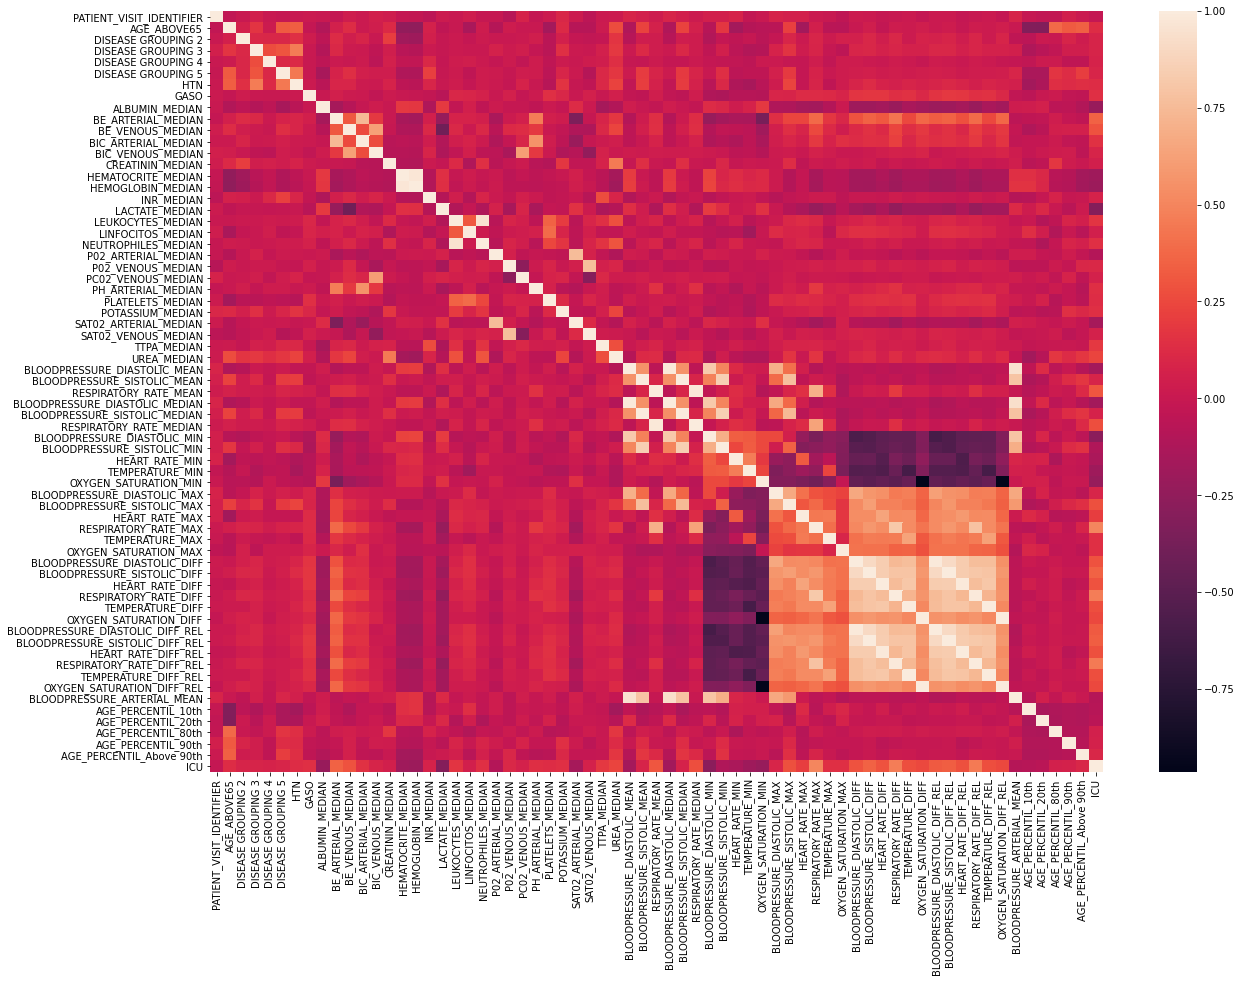

In [34]:
# with a clean database, we can plot the correlation heatmap
plt.figure(figsize=(20,14))
correlation_mat = df_best_features.corr()

sns.heatmap(correlation_mat)

plt.show()

With a clean dataset, Window focused dataframes can be created, in order to study each window separately.

In [35]:
# creating dataframes for each window, with a feature indicating whether the Patient was sent to the ICU on the next window
df_first_window,df_second_window,df_third_window,df_fourth_window = window_df_creation(df_best_features)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:114: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [36]:
print(df_first_window['next_period_ICU'].value_counts())
print(f"\nShape {df_first_window.shape}")

0    326
1     27
Name: next_period_ICU, dtype: int64

Shape (353, 66)


In [37]:
print(df_second_window['next_period_ICU'].value_counts())
print(f"\nShape {df_second_window.shape}")

0    286
1     40
Name: next_period_ICU, dtype: int64

Shape (326, 122)


In [38]:
print(df_third_window['next_period_ICU'].value_counts())
print(f"\nShape {df_third_window.shape}")

0    255
1     31
Name: next_period_ICU, dtype: int64

Shape (286, 176)


In [39]:
print(df_fourth_window['next_period_ICU'].value_counts())
print(f"\nShape {df_fourth_window.shape}")

0    190
1     65
Name: next_period_ICU, dtype: int64

Shape (255, 230)


**Analysing wich model to use for the first window ICU analysis**

# Next Window ICU Models

After running the Hyperoptimization once, and finding the best hyperparameters, that section of the code was commented, due to it taking long to run, and the model being already stable.

* # Window (0-2 hours)

In [40]:
#     train test split
_, _, _, _, x_full, y_full = train_test(df_first_window)  



###############     Logistic Regression     ###############

# init_time = time.time()

# ###### Hyperoptimization ###### --> after discovering the best hyperparameters, we do not need to keep executing that part of the code
# lr_params = {
#     'C': np.random.uniform(low=0.0, high=1.0, size=1000),
#     'penalty': ['l1', 'l2'],
#     'max_iter': np.random.uniform(low=2000, high=10000, size=1000),
# }

# lr_random_search_model = RandomizedSearchCV(
#     estimator=LogisticRegression(
#         fit_intercept=True,
#         class_weight='balanced',
#         random_state=42
#     ), 
#     param_distributions=lr_params,
#     scoring='f1',
#     cv=4,
#     n_iter=2000,
#     n_jobs=-1,
#     random_state=42
# )

# lr_random_search_model.fit(x_full, y_full)
# lr_best_model = lr_random_search_model.best_estimator_


# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lr_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lr_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lr_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lr_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Logistic Regression","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train_cv,
#                 recall_train_cv,
#                 auc_score_train_cv,
#                 avg_prec_train_cv,
#             ],
#             [
#                 "Hyperopt Test",
#                 lr_f1_score_test,
#                 lr_recall_test,
#                 lr_auc_score_test,
#                 lr_avg_prec_test,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lr_fit_time = round((end_time - init_time),2)

# print(f"Logistic Regression done in {lr_fit_time} seconds")

In [41]:
# crossval results

# -------------------  --------  ------  -----  -------------
# Logistic Regression  F1 Score  Recall  AUC    Avg Precision
# Hyperopt Train       0.433     0.814   0.897  0.469
# Hyperopt Test        0.309     0.619   0.675  0.245
# -------------------  --------  ------  -----  -------------
# Logistic Regression done in 271.84 seconds

In [42]:
###############     Logistic Regression     ###############

lr_best_model = LogisticRegression(C=0.2133298308566437, class_weight='balanced',
                   max_iter=8461.978386670755, random_state=42)

lr_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lr_best_model.predict(x_full)
y_prob_test = lr_best_model.predict_proba(x_full)[:, 1]

lr_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lr_f1_score_test = round(f1_score_test[1],4)
lr_recall_test = round(recall_test[1],4)

lr_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [43]:
# ###############     Extra Trees     ############### 
    
# init_time = time.time()


# # Hyperparameter grid
# param_grid = {
#     'n_estimators': np.linspace(1500, 3000).astype(int),
#     'max_depth': list(np.linspace(2, 4).astype(int)),
#     'max_features': ['auto', 'sqrt'],
#     'max_samples': list(np.arange(0.5, 1, 0.1)),
#     'min_samples_split': [5, 10, 20],
#     'bootstrap': [True, False]
# }

# # Estimator for use in random search
# estimator = ExtraTreesClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# xtrees_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 3, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# xtrees_model.fit(x_full, y_full)
# xt_best_model = xtrees_model.best_estimator_


# cv_scores = cross_validate(
#                             xt_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# xt_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# xt_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# xt_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# xt_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Extra Trees","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 xt_f1_score_test_cv,
#                 xt_recall_test_cv,
#                 xt_auc_score_test_cv,
#                 xt_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# xt_fit_time = round((end_time - init_time),2)
# print(f"Extra Trees done in {xt_fit_time} seconds")

In [44]:
# crossval results

# --------------  --------  ------  -----  -------------
# Extra Trees     F1 Score  Recall  AUC    Avg Precision
# Hyperopt Train  0.8734    0.8961  0.969  0.7984
# Hyperopt Test   0.273     0.292   0.7    0.263
# --------------  --------  ------  -----  -------------
# Extra Trees done in 475.69 seconds

In [45]:
###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(class_weight='balanced', max_depth=4, max_features='sqrt',
                     max_samples=0.6, min_samples_split=20, n_estimators=1591,
                     random_state=42)

xt_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = xt_best_model.predict(x_full)
y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

xt_auc_score_test_1 = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
xt_f1_score_test_1 = round(f1_score_test[1],4)
xt_recall_test_1 = round(recall_test[1],4)

xt_avg_prec_test_1 = round(average_precision_score(y_full,y_pred_test),4)

In [46]:
# init_time = time.time()


# # Hyperparameter grid
# param_grid = {"n_estimators": np.linspace(2, 5).astype(int),
#               "boosting_type": ["gbdt","dart","goss"],
#               "subsample": list(np.arange(0.5, 1, 0.2)),
#               "colsample_bytree": list(np.arange(0.5, 0.8, 0.1)),
#               "objective": ["binary","multiclass"],
#               "alpha": list(np.arange(0, 0.6, 0.2)),
#               "max_depth": [2,3,4,5,6]
#              }

# # Estimator for use in random search
# estimator = LGBMClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# lgbm = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 5, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# lgbm.fit(x_full, y_full)
# lgbm_best_model = lgbm.best_estimator_

# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=5,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lgbm_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lgbm_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lgbm_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lgbm_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 lgbm_f1_score_test_cv,
#                 lgbm_recall_test_cv,
#                 lgbm_auc_score_test_cv,
#                 lgbm_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lgbm_fit_time = round(end_time - init_time,3)
# print(f"LGBM done in {lgbm_fit_time} seconds")
# print(lgbm_best_model)

In [47]:
# crossval results

# --------------  --------  ------  -----  -------------
#                 F1 Score  Recall  AUC    Avg Precision
# Hyperopt Train  0.8734    0.8961  0.969  0.7984
# Hyperopt Test   0.313     0.593   0.729  0.33
# --------------  --------  ------  -----  -------------

In [48]:
lgbm_best_model = LGBMClassifier(alpha=0.4, class_weight='balanced',
               colsample_bytree=0.7999999999999999, max_depth=5, n_estimators=4,
               objective='binary', random_state=42,
               subsample=0.8999999999999999)

lgbm_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lgbm_best_model.predict(x_full)
y_prob_test = lgbm_best_model.predict_proba(x_full)[:, 1]

lgbm_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lgbm_f1_score_test = round(f1_score_test[1],4)
lgbm_recall_test = round(recall_test[1],4)

lgbm_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [49]:
###############     Model comparison table     ###############


print(
    tabulate(
        [
            ["Model", "F1-score", "Recall", "AUC", "Avg Precision"],
            [
                "Logistic Regression",
                lr_f1_score_test,
                lr_recall_test,
                lr_auc_score_test,
                lr_avg_prec_test,          
            ],
            [
                "Extra Trees",
                xt_f1_score_test_1,
                xt_recall_test_1,
                xt_auc_score_test_1,
                xt_avg_prec_test_1,
            ],
            [
                "LGBM",
                lgbm_f1_score_test,
                lgbm_recall_test,
                lgbm_auc_score_test,
                lgbm_avg_prec_test
            ],
        ]
    )
)

best_model_1 = xt_best_model
best_model_1

-------------------  --------  ------  ------  -------------
Model                F1-score  Recall  AUC     Avg Precision
Logistic Regression  0.3846    0.7407  0.886   0.2122
Extra Trees          0.6154    0.7407  0.9655  0.4097
LGBM                 0.4538    1.0     0.9402  0.2935
-------------------  --------  ------  ------  -------------


ExtraTreesClassifier(class_weight='balanced', max_depth=4, max_features='sqrt',
                     max_samples=0.6, min_samples_split=20, n_estimators=1591,
                     random_state=42)

All metrics were used to determine the best Model, but a model with balanced metrics would have preference before one that excelled in a  specific metric, such as AUC.

* # Window (2-4 hours)

In [50]:
#     train test split
_, _, _, _, x_full, y_full = train_test(df_second_window)  



# ###############     Logistic Regression     ###############

# init_time = time.time()

# ###### Hyperoptimization ###### --> after discovering the best hyperparameters, we do not need to keep executing that part of the code
# lr_params = {
#     'C': np.random.uniform(low=0.0, high=1.0, size=1000),
#     'penalty': ['l1', 'l2'],
#     'max_iter': np.random.uniform(low=2000, high=10000, size=1000),
# }

# lr_random_search_model = RandomizedSearchCV(
#     estimator=LogisticRegression(
#         fit_intercept=True,
#         class_weight='balanced',
#         random_state=42
#     ), 
#     param_distributions=lr_params,
#     scoring='f1',
#     cv=4,
#     n_iter=2000,
#     n_jobs=-1,
#     random_state=42
# )

# lr_random_search_model.fit(x_full, y_full)
# lr_best_model = lr_random_search_model.best_estimator_


# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lr_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lr_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lr_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lr_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Logistic Regression","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train_cv,
#                 recall_train_cv,
#                 auc_score_train_cv,
#                 avg_prec_train_cv,
#             ],
#             [
#                 "Hyperopt Test",
#                 lr_f1_score_test_cv,
#                 lr_recall_test_cv,
#                 lr_auc_score_test_cv,
#                 lr_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lr_fit_time = round((end_time - init_time),2)

# print(f"Logistic Regression done in {lr_fit_time} seconds")
# print(lr_best_model)

In [51]:
# crossval results

# -------------------  --------  ------  -----  -------------
# Logistic Regression  F1 Score  Recall  AUC    Avg Precision
# Hyperopt Train       0.592     0.883   0.93   0.716
# Hyperopt Test        0.393     0.6     0.792  0.452
# -------------------  --------  ------  -----  -------------
# Logistic Regression done in 187.67 seconds

In [52]:
lr_best_model = LogisticRegression(C=0.8343348698861569, class_weight='balanced',
                   max_iter=4431.907052952959, random_state=42)

lr_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lr_best_model.predict(x_full)
y_prob_test = lr_best_model.predict_proba(x_full)[:, 1]

lr_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lr_f1_score_test = round(f1_score_test[1],4)
lr_recall_test = round(recall_test[1],4)

lr_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [53]:
# ###############     Extra Trees     ############### 
    
# init_time = time.time()


# # Hyperparameter grid
# param_grid = {
#     'n_estimators': np.linspace(1500, 3000).astype(int),
#     'max_depth': list(np.linspace(2, 4).astype(int)),
#     'max_features': ['auto', 'sqrt'],
#     'max_samples': list(np.arange(0.5, 1, 0.1)),
#     'min_samples_split': [5, 10, 20],
#     'bootstrap': [True, False]
# }

# # Estimator for use in random search
# estimator = ExtraTreesClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# xtrees_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 3, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# xtrees_model.fit(x_full, y_full)
# xt_best_model = xtrees_model.best_estimator_


# cv_scores = cross_validate(
#                             xt_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# xt_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# xt_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# xt_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# xt_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Extra Trees","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 xt_f1_score_test_cv,
#                 xt_recall_test_cv,
#                 xt_auc_score_test_cv,
#                 xt_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# xt_fit_time = round((end_time - init_time),2)
# print(f"Extra Trees done in {xt_fit_time} seconds")
# print(xt_best_model)

In [54]:
# crossval results 

# --------------  --------  ------  ------  -------------
# Extra Trees     F1 Score  Recall  AUC     Avg Precision
# Hyperopt Train  0.6154    0.7407  0.9655  0.4097
# Hyperopt Test   0.288     0.2     0.804   0.461
# --------------  --------  ------  ------  -------------

In [55]:
###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_depth=3,
                     max_samples=0.5, min_samples_split=5, n_estimators=1653,
                     random_state=42)

xt_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = xt_best_model.predict(x_full)
y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

xt_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
xt_f1_score_test = round(f1_score_test[1],4)
xt_recall_test = round(recall_test[1],4)

xt_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [56]:
# ##############     LGBM     ###############

# init_time = time.time()


# # Hyperparameter grid
# param_grid = {"n_estimators": np.linspace(2, 5).astype(int),
#               "boosting_type": ["gbdt","dart","goss"],
#               "subsample": list(np.arange(0.5, 1, 0.2)),
#               "colsample_bytree": list(np.arange(0.5, 0.8, 0.1)),
#               "objective": ["binary","multiclass"],
#               "alpha": list(np.arange(0, 0.6, 0.2)),
#               "max_depth": [2,3,4,5,6],
#               "num_leaves": np.linspace(20, 40).astype(int),
#              }

# # Estimator for use in random search
# estimator = LGBMClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# lgbm = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 5, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# lgbm.fit(x_full, y_full)
# lgbm_best_model = lgbm.best_estimator_

# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=5,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lgbm_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lgbm_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lgbm_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lgbm_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 lgbm_f1_score_test_cv,
#                 lgbm_recall_test_cv,
#                 lgbm_auc_score_test_cv,
#                 lgbm_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lgbm_fit_time = round(end_time - init_time,3)
# print(f"LGBM done in {lgbm_fit_time} seconds")
# print(lgbm_best_model)

In [57]:
# crossval results

# --------------  --------  ------  ------  -------------
#                 F1 Score  Recall  AUC     Avg Precision
# Hyperopt Train  0.6154    0.7407  0.9655  0.4097
# Hyperopt Test   0.339     0.525   0.758   0.447
# --------------  --------  ------  ------  -------------

In [58]:
###############     LGBM     ###############

lgbm_best_model = LGBMClassifier(alpha=0.4, class_weight='balanced', colsample_bytree=0.5,
               max_depth=6, n_estimators=4, num_leaves=28, objective='binary',
               random_state=42, subsample=0.8999999999999999)

lgbm_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lgbm_best_model.predict(x_full)
y_prob_test = lgbm_best_model.predict_proba(x_full)[:, 1]

lgbm_auc_score_test_2 = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lgbm_f1_score_test_2 = round(f1_score_test[1],4)
lgbm_recall_test_2 = round(recall_test[1],4)

lgbm_avg_prec_test_2 = round(average_precision_score(y_full,y_pred_test),4)

In [59]:
###############     Model comparison table     ###############


print(
    tabulate(
        [
            ["Model", "F1-score", "Recall", "AUC", "Avg Precision"],
            [
                "Logistic Regression",
                lr_f1_score_test,
                lr_recall_test,
                lr_auc_score_test,
                lr_avg_prec_test,          
            ],
            [
                "Extra Trees",
                xt_f1_score_test,
                xt_recall_test,
                xt_auc_score_test,
                xt_avg_prec_test,
            ],
            [
                "LGBM",
                lgbm_f1_score_test_2,
                lgbm_recall_test_2,
                lgbm_auc_score_test_2,
                lgbm_avg_prec_test_2
            ],
        ]
    )
)


best_model_2 = lgbm_best_model
best_model_2

-------------------  --------  ------  ------  -------------
Model                F1-score  Recall  AUC     Avg Precision
Logistic Regression  0.5645    0.875   0.9178  0.3799
Extra Trees          0.5937    0.475   0.9503  0.4405
LGBM                 0.6897    1.0     0.9884  0.5263
-------------------  --------  ------  ------  -------------


LGBMClassifier(alpha=0.4, class_weight='balanced', colsample_bytree=0.5,
               max_depth=6, n_estimators=4, num_leaves=28, objective='binary',
               random_state=42, subsample=0.8999999999999999)

* # Window (4-6 hours)

In [60]:
#     train test split
_, _, _, _, x_full, y_full = train_test(df_third_window)  



# ###############     Logistic Regression     ###############

# init_time = time.time()

# ###### Hyperoptimization ###### --> after discovering the best hyperparameters, we do not need to keep executing that part of the code
# lr_params = {
#     'C': np.random.uniform(low=0.0, high=1.0, size=1000),
#     'penalty': ['l1', 'l2'],
#     'max_iter': np.random.uniform(low=2000, high=10000, size=1000),
# }

# lr_random_search_model = RandomizedSearchCV(
#     estimator=LogisticRegression(
#         fit_intercept=True,
#         class_weight='balanced',
#         random_state=42
#     ), 
#     param_distributions=lr_params,
#     scoring='f1',
#     cv=4,
#     n_iter=2000,
#     n_jobs=-1,
#     random_state=42
# )

# lr_random_search_model.fit(x_full, y_full)
# lr_best_model = lr_random_search_model.best_estimator_


# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lr_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lr_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lr_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lr_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Logistic Regression","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train_cv,
#                 recall_train_cv,
#                 auc_score_train_cv,
#                 avg_prec_train_cv,
#             ],
#             [
#                 "Hyperopt Test",
#                 lr_f1_score_test_cv,
#                 lr_recall_test_cv,
#                 lr_auc_score_test_cv,
#                 lr_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lr_fit_time = round((end_time - init_time),2)

# print(f"Logistic Regression done in {lr_fit_time} seconds")
# print(lr_best_model)

In [61]:
#  crossval results

# -------------------  --------  ------  -----  -------------
# Logistic Regression  F1 Score  Recall  AUC    Avg Precision
# Hyperopt Train       0.285     0.666   0.711  0.25
# Hyperopt Test        0.282     0.647   0.734  0.427
# -------------------  --------  ------  -----  -------------

In [62]:
lr_best_model = LogisticRegression(C=0.009174855205852595, class_weight='balanced',
                   max_iter=7681.345742769994, random_state=42)

lr_best_model.fit(x_full, y_full)

###### Avaliando hyperopt ######
y_pred_test = lr_best_model.predict(x_full)
y_prob_test = lr_best_model.predict_proba(x_full)[:, 1]

lr_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lr_f1_score_test = round(f1_score_test[1],4)
lr_recall_test = round(recall_test[1],4)

lr_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [63]:
# ###############     Extra Trees     ############### 
    
# init_time = time.time()


# # Hyperparameter grid
# param_grid = {
#     'n_estimators': np.linspace(1500, 3000).astype(int),
#     'max_depth': list(np.linspace(2, 4).astype(int)),
#     'max_features': ['auto', 'sqrt'],
#     'max_samples': list(np.arange(0.5, 1, 0.1)),
#     'min_samples_split': [5, 10, 20],
#     'bootstrap': [True, False]
# }

# # Estimator for use in random search
# estimator = ExtraTreesClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# xtrees_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 3, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# xtrees_model.fit(x_full, y_full)
# xt_best_model = xtrees_model.best_estimator_


# cv_scores = cross_validate(
#                             xt_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# xt_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# xt_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# xt_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# xt_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Extra Trees","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 xt_f1_score_test_cv,
#                 xt_recall_test_cv,
#                 xt_auc_score_test_cv,
#                 xt_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# xt_fit_time = round((end_time - init_time),2)
# print(f"Extra Trees done in {xt_fit_time} seconds")
# print(xt_best_model)

In [64]:
# crossval results

# --------------  --------  ------  ------  -------------
# Extra Trees     F1 Score  Recall  AUC     Avg Precision
# Hyperopt Train  0.6154    0.7407  0.9655  0.4097
# Hyperopt Test   0.466     0.643   0.811   0.375
# --------------  --------  ------  ------  -------------

In [65]:
###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_features='sqrt',
                     max_samples=0.5, min_samples_split=10, n_estimators=2632,
                     random_state=42)

xt_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = xt_best_model.predict(x_full)
y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

xt_auc_score_test_3 = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
xt_f1_score_test_3 = round(f1_score_test[1],4)
xt_recall_test_3 = round(recall_test[1],4)

xt_avg_prec_test_3 = round(average_precision_score(y_full,y_pred_test),4)

In [66]:
# ##############     LGBM     ###############

# init_time = time.time()


# # Hyperparameter grid
# param_grid = {"n_estimators": np.linspace(2, 5).astype(int),
#               "boosting_type": ["gbdt","dart","goss"],
#               "subsample": list(np.arange(0.5, 1, 0.2)),
#               "colsample_bytree": list(np.arange(0.5, 0.8, 0.1)),
#               "objective": ["binary","multiclass"],
#               "alpha": list(np.arange(0, 0.6, 0.2)),
#               "max_depth": [2,3,4,5,6],
#               "num_leaves": np.linspace(20, 40).astype(int),
#              }

# # Estimator for use in random search
# estimator = LGBMClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# lgbm = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 5, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# lgbm.fit(x_full, y_full)
# lgbm_best_model = lgbm.best_estimator_

# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=5,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lgbm_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lgbm_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lgbm_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lgbm_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 lgbm_f1_score_test_cv,
#                 lgbm_recall_test_cv,
#                 lgbm_auc_score_test_cv,
#                 lgbm_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lgbm_fit_time = round(end_time - init_time,3)
# print(f"LGBM done in {lgbm_fit_time} seconds")
# print(lgbm_best_model)

In [67]:
# crossval results

# --------------  --------  ------  ------  -------------
#                 F1 Score  Recall  AUC     Avg Precision
# Hyperopt Train  0.6154    0.7407  0.9655  0.4097
# Hyperopt Test   0.24      0.533   0.712   0.319
# --------------  --------  ------  ------  -------------

In [68]:
###############     LGBM     ###############

lgbm_best_model = LGBMClassifier(alpha=0.4, boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, max_depth=2, n_estimators=2, num_leaves=39,
               objective='binary', random_state=42, subsample=0.5)

lgbm_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lgbm_best_model.predict(x_full)
y_prob_test = lgbm_best_model.predict_proba(x_full)[:, 1]

lgbm_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lgbm_f1_score_test = round(f1_score_test[1],4)
lgbm_recall_test = round(recall_test[1],4)

lgbm_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [69]:
###############     Model comparison table     ###############


print(
    tabulate(
        [
            ["Model", "F1-score", "Recall", "AUC", "Avg Precision"],
            [
                "Logistic Regression",
                lr_f1_score_test,
                lr_recall_test,
                lr_auc_score_test,
                lr_avg_prec_test,          
            ],
            [
                "Extra Trees",
                xt_f1_score_test_3,
                xt_recall_test_3,
                xt_auc_score_test_3,
                xt_avg_prec_test_3,
            ],
            [
                "LGBM",
                lgbm_f1_score_test,
                lgbm_recall_test,
                lgbm_auc_score_test,
                lgbm_avg_prec_test
            ],
        ]
    )
)


best_model_3 = xt_best_model
best_model_3

-------------------  --------  ------  ------  -------------
Model                F1-score  Recall  AUC     Avg Precision
Logistic Regression  0.3056    0.7097  0.7175  0.1696
Extra Trees          0.6019    1.0     0.9784  0.4306
LGBM                 0.4252    0.871   0.8493  0.2589
-------------------  --------  ------  ------  -------------


ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_features='sqrt',
                     max_samples=0.5, min_samples_split=10, n_estimators=2632,
                     random_state=42)

* # Window (6-12 hours)

In [70]:
#     train test split
_, _, _, _, x_full, y_full = train_test(df_fourth_window)  


# ###############     Logistic Regression     ###############

# init_time = time.time()

# ###### Hyperoptimization ###### --> after discovering the best hyperparameters, we do not need to keep executing that part of the code
# lr_params = {
#     'C': np.random.uniform(low=0.0, high=1.0, size=1000),
#     'penalty': ['l1', 'l2'],
#     'max_iter': np.random.uniform(low=2000, high=10000, size=1000),
# }

# lr_random_search_model = RandomizedSearchCV(
#     estimator=LogisticRegression(
#         fit_intercept=True,
#         class_weight='balanced',
#         random_state=42
#     ), 
#     param_distributions=lr_params,
#     scoring='f1',
#     cv=4,
#     n_iter=2000,
#     n_jobs=-1,
#     random_state=42
# )

# lr_random_search_model.fit(x_full, y_full)
# lr_best_model = lr_random_search_model.best_estimator_


# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lr_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lr_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lr_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lr_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)



# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Logistic Regression","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train_cv,
#                 recall_train_cv,
#                 auc_score_train_cv,
#                 avg_prec_train_cv,
#             ],
#             [
#                 "Hyperopt Test",
#                 lr_f1_score_test_cv,
#                 lr_recall_test_cv,
#                 lr_auc_score_test_cv,
#                 lr_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lr_fit_time = round((end_time - init_time),2)

# print(f"Logistic Regression done in {lr_fit_time} seconds")
# lr_best_model

In [71]:
# crossval results

# -------------------  --------  ------  -----  -------------
# Logistic Regression  F1 Score  Recall  AUC    Avg Precision
# Hyperopt Train       0.816     0.944   0.969  0.912
# Hyperopt Test        0.599     0.722   0.817  0.615
# -------------------  --------  ------  -----  -------------

In [72]:
lr_best_model = LogisticRegression(C=0.8289805678387626, class_weight='balanced',
                   max_iter=9335.5416957698, random_state=42)

lr_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lr_best_model.predict(x_full)
y_prob_test = lr_best_model.predict_proba(x_full)[:, 1]

lr_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lr_f1_score_test = round(f1_score_test[1],4)
lr_recall_test = round(recall_test[1],4)

lr_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [73]:
# ###############     Extra Trees     ############### 
    
# init_time = time.time()


# # Hyperparameter grid
# param_grid = {
#     'n_estimators': np.linspace(1500, 3000).astype(int),
#     'max_depth': list(np.linspace(2, 4).astype(int)),
#     'max_features': ['auto', 'sqrt'],
#     'max_samples': list(np.arange(0.5, 1, 0.1)),
#     'min_samples_split': [5, 10, 20],
#     'bootstrap': [True, False]
# }

# # Estimator for use in random search
# estimator = ExtraTreesClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# xtrees_model = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 3, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# xtrees_model.fit(x_full, y_full)
# xt_best_model = xtrees_model.best_estimator_


# cv_scores = cross_validate(
#                             xt_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=4,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# xt_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# xt_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# xt_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# xt_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["Extra Trees","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 xt_f1_score_test_cv,
#                 xt_recall_test_cv,
#                 xt_auc_score_test_cv,
#                 xt_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# xt_fit_time = round((end_time - init_time),2)
# print(f"Extra Trees done in {xt_fit_time} seconds")
# print(xt_best_model)

In [74]:
# crossval results

# --------------  --------  ------  ------  -------------
# Extra Trees     F1 Score  Recall  AUC     Avg Precision
# Hyperopt Train  0.6154    0.7407  0.9655  0.4097
# Hyperopt Test   0.746     0.877   0.939   0.876
# --------------  --------  ------  ------  -------------

In [75]:
###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_samples=0.5,
                     min_samples_split=20, n_estimators=2816, random_state=42)

xt_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = xt_best_model.predict(x_full)
y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

xt_auc_score_test_4 = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
xt_f1_score_test_4 = round(f1_score_test[1],4)
xt_recall_test_4 = round(recall_test[1],4)

xt_avg_prec_test_4 = round(average_precision_score(y_full,y_pred_test),4)

In [76]:
# ##############     LGBM     ###############

# init_time = time.time()


# # Hyperparameter grid
# param_grid = {"n_estimators": np.linspace(2, 5).astype(int),
#               "boosting_type": ["gbdt","dart","goss"],
#               "subsample": list(np.arange(0.5, 1, 0.2)),
#               "colsample_bytree": list(np.arange(0.5, 0.8, 0.1)),
#               "objective": ["binary","multiclass"],
#               "alpha": list(np.arange(0, 0.6, 0.2)),
#               "max_depth": [2,3,4,5,6],
#               "num_leaves": np.linspace(20, 40).astype(int),
#              }

# # Estimator for use in random search
# estimator = LGBMClassifier(class_weight='balanced',random_state=42)

# # Create the random search model
# lgbm = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
#                         scoring = 'f1', cv = 5, 
#                         n_iter = 100, verbose = 0,
#                         random_state=42)

# # Fit 
# lgbm.fit(x_full, y_full)
# lgbm_best_model = lgbm.best_estimator_

# cv_scores = cross_validate(
#                             lr_best_model, # best_estimator da RandomSearchCV
#                             x_full,
#                             y_full,
#                             cv=5,
#                             scoring=('f1', 'average_precision', 'roc_auc','recall'),
#                             return_train_score=True
#                             )

# f1_score_train_cv =  round(np.mean(cv_scores['train_f1']),3)
# recall_train_cv =  round(np.mean(cv_scores['train_recall']),3)
# auc_score_train_cv =  round(np.mean(cv_scores['train_roc_auc']),3)
# avg_prec_train_cv =  round(np.mean(cv_scores['train_average_precision']),3)

# lgbm_f1_score_test_cv = round(np.mean(cv_scores['test_f1']),3)
# lgbm_recall_test_cv = round(np.mean(cv_scores['test_recall']),3)
# lgbm_auc_score_test_cv = round(np.mean(cv_scores['test_roc_auc']),3)
# lgbm_avg_prec_test_cv = round(np.mean(cv_scores['test_average_precision']),3)


# ###### Tabela comparativa ######
# print(
#     tabulate(
#         [
#             ["","F1 Score", "Recall", "AUC", "Avg Precision"],
#             [
#                 "Hyperopt Train",
#                 f1_score_train,
#                 recall_train,
#                 auc_score_train,
#                 avg_prec_train,
#             ],
#             [
#                 "Hyperopt Test",
#                 lgbm_f1_score_test_cv,
#                 lgbm_recall_test_cv,
#                 lgbm_auc_score_test_cv,
#                 lgbm_avg_prec_test_cv,
#             ],
#         ]
#     )
# )

# end_time = time.time()
# lgbm_fit_time = round(end_time - init_time,3)
# print(f"LGBM done in {lgbm_fit_time} seconds")
# print(lgbm_best_model)

In [77]:
# crossval results

# --------------  --------  ------  ------  -------------
#                 F1 Score  Recall  AUC     Avg Precision
# Hyperopt Train  0.6154    0.7407  0.9655  0.4097
# Hyperopt Test   0.632     0.723   0.842   0.676
# --------------  --------  ------  ------  -------------

In [78]:
###############     LGBM     ###############

lgbm_best_model = LGBMClassifier(alpha=0.4, boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, max_depth=2, n_estimators=2, num_leaves=39,
               objective='binary', random_state=42, subsample=0.5)

lgbm_best_model.fit(x_full, y_full)

###### Avaliando hyperopt - test ######
y_pred_test = lgbm_best_model.predict(x_full)
y_prob_test = lgbm_best_model.predict_proba(x_full)[:, 1]

lgbm_auc_score_test = round(roc_auc_score(y_full,y_prob_test),4)

_,recall_test,f1_score_test,_ = precision_recall_fscore_support(y_full,y_pred_test)
lgbm_f1_score_test = round(f1_score_test[1],4)
lgbm_recall_test = round(recall_test[1],4)

lgbm_avg_prec_test = round(average_precision_score(y_full,y_pred_test),4)

In [79]:
###############     Model comparison table     ###############


print(
    tabulate(
        [
            ["Model", "F1-score", "Recall", "AUC", "Avg Precision"],
            [
                "Logistic Regression",
                lr_f1_score_test,
                lr_recall_test,
                lr_auc_score_test,
                lr_avg_prec_test,          
            ],
            [
                "Extra Trees",
                xt_f1_score_test_4,
                xt_recall_test_4,
                xt_auc_score_test_4,
                xt_avg_prec_test_4,
            ],
            [
                "LGBM",
                lgbm_f1_score_test,
                lgbm_recall_test,
                lgbm_auc_score_test,
                lgbm_avg_prec_test,
            ],
        ]
    )
)


best_model_4 = xt_best_model
best_model_4

-------------------  --------  ------  ------  -------------
Model                F1-score  Recall  AUC     Avg Precision
Logistic Regression  0.7922    0.9385  0.9617  0.6589
Extra Trees          0.8477    0.9846  0.9904  0.7367
LGBM                 0.7692    0.8462  0.9238  0.6359
-------------------  --------  ------  ------  -------------


ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_samples=0.5,
                     min_samples_split=20, n_estimators=2816, random_state=42)

# **Best model for each window**

* First Window: Extra Trees 
* Second Window: LGBM
* Third Window: Extra Trees 
* Fourth Window: Extra Trees 

In [80]:
print(
    tabulate(
        [
            ["Model", "F1-score", "Recall", "AUC", "Avg Precision"],
            [
                "W1 - Extra Trees",
                xt_f1_score_test_1,
                xt_recall_test_1,
                xt_auc_score_test_1,
                xt_avg_prec_test_1,          
            ],
            [
                "W2 - Extra Trees",
                lgbm_f1_score_test_2,
                lgbm_recall_test_2,
                lgbm_auc_score_test_2,
                lgbm_avg_prec_test_2, 
            ],
            [
                "W3 - Extra Trees",
                xt_f1_score_test_3,
                xt_recall_test_3,
                xt_auc_score_test_3,
                xt_avg_prec_test_3 
            ],
            [
                "W4 - LGBM",
                xt_f1_score_test_4,
                xt_recall_test_4,
                xt_auc_score_test_4,
                xt_avg_prec_test_4,
            ],
        ]
    )
)

----------------  --------  ------  ------  -------------
Model             F1-score  Recall  AUC     Avg Precision
W1 - Extra Trees  0.6154    0.7407  0.9655  0.4097
W2 - Extra Trees  0.6897    1.0     0.9884  0.5263
W3 - Extra Trees  0.6019    1.0     0.9784  0.4306
W4 - LGBM         0.8477    0.9846  0.9904  0.7367
----------------  --------  ------  ------  -------------


Based on the metrics above, there will be a high success rate in predicting, for each window, which patients are going to be sent to the ICU on the next window. But further dedicaton should be spent in improving the hyperparameters, in order to check for eventual overfitting, even if the hyperoptimization was done using cross validation techniques.

# Combined Proba

Now we need to create new dataframes without the feature difference features, in order to be able to use the new df's features across all windows. In these dataframes, we wil have the info of how many patients went to the ICU on other windows, and features related to the first window.

In [81]:
df_first_proba,df_second_proba,df_third_proba,df_fourth_proba = df_proba_create(df_best_features)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [82]:
df_first_proba.shape

(353, 65)

In [83]:
df_second_proba.shape

(353, 65)

In [84]:
df_third_proba.shape

(353, 65)

In [85]:
df_fourth_proba.shape

(353, 65)

**Finding the best models for the predict proba dataframes. For that, we train the models with the dataframes related to their windows, but after we find the best model, we fit the first widnow dataframe in order to have all patients in our final dataframe.**

**After that, we have to calibrate the predict probas from the Tree Models in order to use them in a combined fashion, based on the following [article](https://gdmarmerola.github.io/probability-calibration/)**

In [86]:
# lr_best_model_1, xt_best_model_1, lgbm_best_model_1 = model_comparison(df_first_proba)
# best_model_proba_1 = xt_best_model_1
# best_model_proba_1

In [87]:
_, _, _, _, x_full, y_full = train_test(df_first_proba)

###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_depth=3,
                     max_samples=0.7999999999999999, min_samples_split=20,
                     n_estimators=2724, random_state=42)

xt_best_model.fit(x_full, y_full)
xt1_y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

df_proba_1 = lr_proba(xt_best_model,df_first_proba)
df_proba_1.drop(columns=[0],inplace=True)
df_proba_1.columns = ['ICU_1']
df_proba_1

,ICU_1
id,
0,0.013568
2,0.108901
3,0.009321
4,0.021117
5,0.011103
...,...
380,0.012437
381,0.084681
382,0.008825


In [88]:
# lr_best_model_2, xt_best_model_2, lgbm_best_model_2 = model_comparison(df_second_proba)
# best_model_proba_2 = xt_best_model_2
# best_model_proba_2

In [89]:
_, _, _, _, x_full, y_full = train_test(df_first_proba)

###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_depth=2,
                     max_features='sqrt', max_samples=0.8999999999999999, min_samples_split=20,
                     n_estimators=1714, random_state=42)

xt_best_model.fit(x_full, y_full)

xt2_y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

df_proba_2 = lr_proba(xt_best_model,df_first_proba)
df_proba_2.drop(columns=[0],inplace=True)
df_proba_2.columns = ['ICU_2']
df_proba_2

,ICU_2
id,
0,0.024784
2,0.142660
3,0.018318
4,0.031084
5,0.018344
...,...
380,0.022061
381,0.110276
382,0.017224


In [90]:
# lr_best_model_3, xt_best_model_3, lgbm_best_model_3 = model_comparison(df_third_proba)
# best_model_proba_3 = xt_best_model_3
# best_model_proba_3

In [91]:
_, _, _, _, x_full, y_full = train_test(df_first_proba)

###############     Extra Trees     ###############

xt_best_model = ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_features='sqrt',
                     max_samples=0.8999999999999999, min_samples_split=10,
                     n_estimators=2479, random_state=42)

xt_best_model.fit(x_full, y_full)

xt3_y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

df_proba_3 = lr_proba(xt_best_model,df_first_proba)
df_proba_3.drop(columns=[0],inplace=True)
df_proba_3.columns = ['ICU_3']
df_proba_3

,ICU_3
id,
0,0.015586
2,0.105904
3,0.011382
4,0.018735
5,0.009514
...,...
380,0.012542
381,0.083904
382,0.010254


In [92]:
# lr_best_model_4, xt_best_model_4, lgbm_best_model_4 = model_comparison(df_fourth_proba)
# best_model_proba_4 = xt_best_model_4
# best_model_proba_4

In [93]:
_, _, _, _, x_full, y_full = train_test(df_first_proba)

###############     LGBM     ###############

lgbm_best_model = LGBMClassifier(alpha=0.4, class_weight='balanced', colsample_bytree=0.5,
               max_depth=3, n_estimators=4, num_leaves=24, objective='binary',
               random_state=42, subsample=0.7)

lgbm_best_model.fit(x_full, y_full)

lgbm4_y_prob_test = lgbm_best_model.predict_proba(x_full)[:, 1]

df_proba_4 = lr_proba(lgbm_best_model,df_first_proba)
df_proba_4.drop(columns=[0],inplace=True)
df_proba_4.columns = ['ICU_4']
df_proba_4

,ICU_4
id,
0,0.376425
2,0.449104
3,0.376425
4,0.402397
5,0.376425
...,...
380,0.402397
381,0.474058
382,0.376425


In [94]:
# _, _, _, _, x_full, y_full = train_test(df_first_proba)

# ###############     Extra Trees     ###############

# xt_best_model = ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_depth=2,
#                      max_features='sqrt', max_samples=0.5, min_samples_split=10,
#                      n_estimators=1836, random_state=42)

# xt_best_model.fit(x_full, y_full)

# xt4_y_prob_test = xt_best_model.predict_proba(x_full)[:, 1]

# df_proba_4 = lr_proba(xt_best_model,df_first_proba)
# df_proba_4.drop(columns=[0],inplace=True)
# df_proba_4.columns = ['ICU_4']
# df_proba_4

In [95]:
df_combined_proba = df_proba_1.merge(df_proba_2,left_index = True,right_index = True)
df_combined_proba = df_combined_proba.merge(df_proba_3,left_index = True,right_index = True)
df_combined_proba = df_combined_proba.merge(df_proba_4,left_index = True,right_index = True)
df_combined_proba['combined_ICU_proba'] = round(df_combined_proba['ICU_1'] + df_combined_proba['ICU_2'] + df_combined_proba['ICU_3'] + df_combined_proba['ICU_4'],2)
df_combined_proba

,ICU_1,ICU_2,ICU_3,ICU_4,combined_ICU_proba
id,,,,,
0,0.013568,0.024784,0.015586,0.376425,0.43
2,0.108901,0.142660,0.105904,0.449104,0.81
3,0.009321,0.018318,0.011382,0.376425,0.42
4,0.021117,0.031084,0.018735,0.402397,0.47
5,0.011103,0.018344,0.009514,0.376425,0.42
...,...,...,...,...,...
380,0.012437,0.022061,0.012542,0.402397,0.45
381,0.084681,0.110276,0.083904,0.474058,0.75
382,0.008825,0.017224,0.010254,0.376425,0.41


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


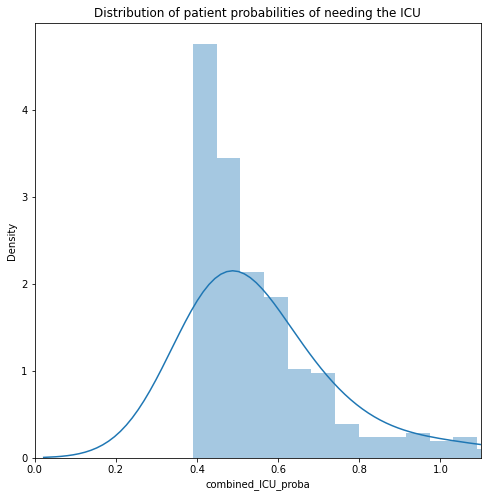

In [96]:
plt.figure(figsize=[8, 8])

ax = sns.distplot(df_combined_proba['combined_ICU_proba'])
plt.title('Distribution of patient probabilities of needing the ICU')
ax.set(xlim=(0, 1.1));

In [97]:
# Patients below the 50% threshold
len(df_combined_proba[df_combined_proba['combined_ICU_proba']<0.5]['combined_ICU_proba'])

160

In [98]:
# Patients above the 50% threshold
len(df_combined_proba[df_combined_proba['combined_ICU_proba']>=0.5]['combined_ICU_proba'])

193

# Combined Probability usage 

As we want the probability of a combined event, we sum the probabilities of each individual event happening. With this approach, we are checking whether the patient will be sent to the ICU in any given window.  That information can be of great use to the hospital in checking, with the first exam results, if a patient is more likely to need an ICU spot. And when combined allied with the previous models, the patients wigh a higher risk can be monitored and analysed if in the following window the transfer to the ICU will be required.

In [99]:
# total Notebook run  time

notebook_stop = time.time()
total_run_time = round(notebook_stop - notebook_start,3)
total_run_time_minutes = round(total_run_time/60,2)
total_run_time_minutes

1.35